# BERT tutorial

---

## Data preparation

### Load the dataset

In [152]:
import pandas as pd

df = pd.read_csv("./dataset_writeups/dataset_writeups.csv")
df.head()

,filename,category,topic,text
0,writeup_0wcYN1wDDobsfFzHF7Npz_tagged.txt,web_exploitation,overview,This challenge was a SQL injection challenge w...
1,writeup_0wcYN1wDDobsfFzHF7Npz_tagged.txt,web_exploitation,attack_execution,We started by entering a random username and p...
2,writeup_0wcYN1wDDobsfFzHF7Npz_tagged.txt,web_exploitation,analysis,Lessons Learned: SQL injection can be a danger...
3,writeup_87UfUw9vx6wZmcPf72YHN_tagged.txt,web_exploitation,analysis,We can start by looking for input fields on th...
4,writeup_87UfUw9vx6wZmcPf72YHN_tagged.txt,web_exploitation,attack_execution,We can start by injecting a simple file path i...


In [153]:
df["topic"].value_counts()

attack_execution    55
analysis            50
overview            19
Name: topic, dtype: int64

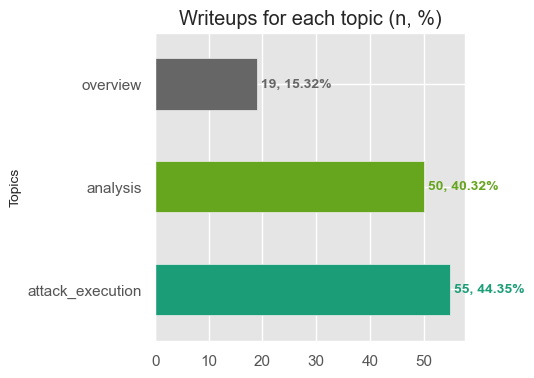

In [154]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")
num_classes = len(df["topic"].value_counts())
colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)
df["topic"].value_counts().plot.barh(title="Writeups for each topic (n, %)", 
                                                 ylabel="Topics",
                                                 color=colors,
                                                 figsize=(4,4))

for i, v in enumerate(df["topic"].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%", 
           color=c, 
           va="center", 
           fontweight="bold")

For the purpose of classification, we need numeric labels. Therefore, we map the topics descriptions to integers as follows:

In [155]:
# map topics descriptions to labels
df["label"] = df["topic"].map({"overview": 0,
                                "analysis": 1,
                                "attack_execution": 2})
# drop unused column
df = df.drop(["topic"], axis=1)

df["label"].value_counts()

2    55
1    50
0    19
Name: label, dtype: int64

### [Optional] Observe random samples

Although it is not strictly necessary to the goal of text classification, we might want to inspect some random samples from different topics to develop a better understanding of the data.

In [156]:
def print_rand_sample(df, col_name, col_value, chars=180):
  '''print a random sample
  Args:
    - df: input dataframe
    - col_name: column to use as filter (e.g. label)
    - col_value: value of col_name to use as filter 
    - chars (optional, def:180) max number of characters to display
  '''
  text = df[df[col_name]==col_value].sample()["text"].values[0]
  print(f"{col_value}: {text[0:chars]} ...\n")

In [159]:
num_labels = len(df["label"].unique())
for label_idx in range(num_labels):
    print_rand_sample(df, "label", label_idx)

0: The challenge involves exploiting a website that hasn't been fully finished to find a flag. We can change the user agent of our browser using a browser extension or by modifying th ...

1: We can view the cookie using our browser's developer tools or a tool like Burp Suite. We can see that the cookie has a name of `name` and a value that corresponds to the option we  ...

2: To exploit the vulnerability, we can enter a wildcard character "%" as the username and password. When we do that, we get a message saying "Only the admin is allowed to log in!". T ...



### Split in train and test set

In [160]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df["label"].values, num_classes=num_classes)
# split the dataset into a train set (80%) and a temporary set (20%)
X_train, X_temp, y_train, y_temp = train_test_split(df["text"], y, test_size=0.2, random_state=42)
# split the temporary set into a validation set (10%) and a test set (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.head()

67     The challenge presents a login page that accep...
12     We can start by looking for input fields on th...
24     To exploit the vulnerability, we can enter "lo...
45     The challenge involves exploiting cookies to g...
107    We can intercept this request using Burp Suite...
Name: text, dtype: object

---

## Data modeling

### Load BERT with TensorFlow Hub

We make use of the universal-sentence-encoder-cmlm/multilingual-base model, a universal sentence encoder that supports more than 100 languages. It is trained using a conditional masked language model, as described in the reference paper.

What we want to achieve is to turn text into high-dimensional vectors that capture sentence-level semantics. Therefore, we proceed by loading the preprocessor and the encoder layers from the endpoints provided by TensorFlow Hub, and define a simple function to get the embeddings from input text.

In [161]:
#! pip install tensorflow-text
import tensorflow_hub as tf_hub
import tensorflow_text as tf_text

preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3" # "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-large/1" # "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

bert_preprocessor = tf_hub.KerasLayer(preprocessor_url)
bert_encoder = tf_hub.KerasLayer(encoder_url)

As the model is based on the BERT transformer architecture, it will generate a pooled_output (output embedding of the entire sequence) of shape [batch size, 768], as displayed in the following example:

In [162]:
def get_embeddings(sentences):
	'''return BERT-like embeddings of input text
	Args:
		- sentences: list of strings
	Output:
		- BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
	'''
	return bert_encoder(bert_preprocessor(sentences))["pooled_output"]

get_embeddings(
	["This is just a sentence to test the latter function."]
)

<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[ 0.0731841 ,  0.02042833,  0.31886306, ..., -0.7665954 ,
        -0.25669706, -1.1481299 ]], dtype=float32)>

### [Optional] Observe semantic textual similarities

As the embeddings provide a vector representation of sentence-level semantics, we might want to observe the similarities between different sentences.

In [163]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def plot_similarity(features, sentences):
	"""Plot a similarity matrix of the embeddings."""
	cos_sim = cosine_similarity(features)
	fig = plt.figure(figsize=(5, 5))
	sns.set(font_scale=1)
	cbar_kws=dict(use_gridspec=False, location="left")
	g = sns.heatmap(
		cos_sim, xticklabels=sentences, yticklabels=sentences,
		vmin=0, vmax=1, annot=True, cmap="Blues", 
		cbar_kws=cbar_kws)
	g.tick_params(labelright=True, labelleft=False)
	g.set_yticklabels(sentences, rotation=0)
	g.set_title("Semantic Textual Similarity")

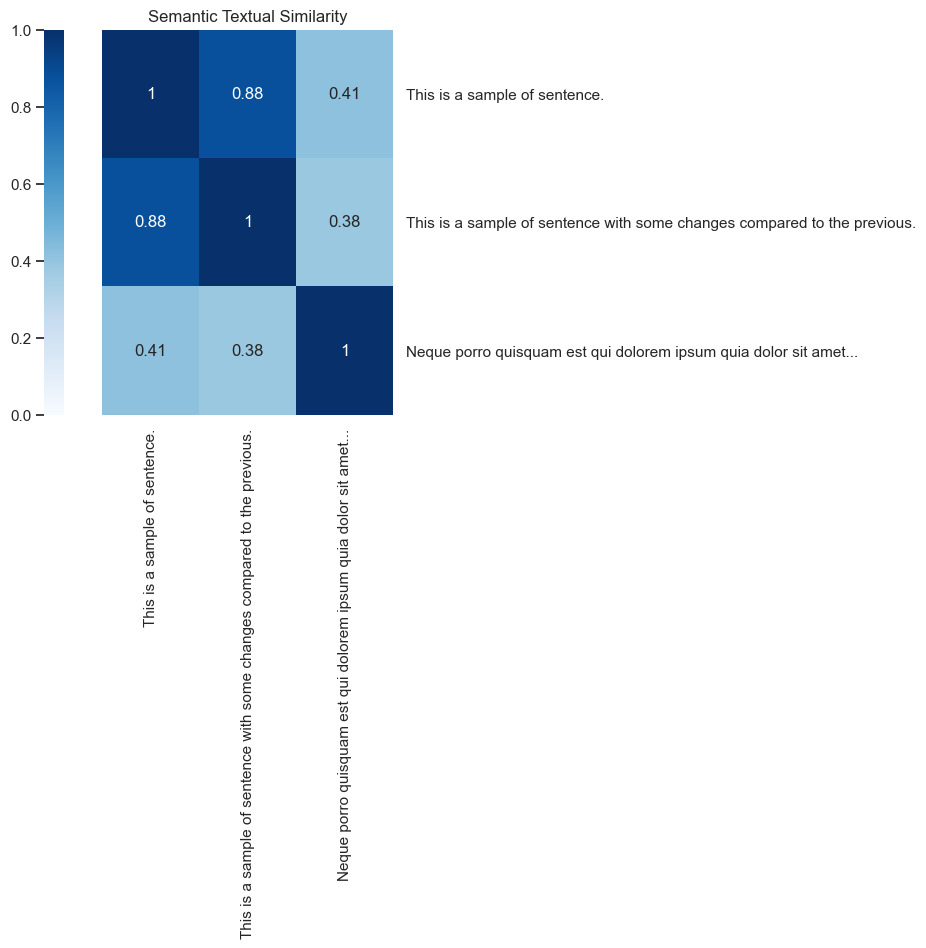

In [74]:
sample_sentences = [
    "This is a sample of sentence.",
    "This is a sample of sentence with some changes compared to the previous.",
    "Neque porro quisquam est qui dolorem ipsum quia dolor sit amet..."
]

plot_similarity(get_embeddings(sample_sentences), sample_sentences)

### Create and train the classification model

As we are facing a multi-class classification problem, and we previously noticed that our topics distribution is slightly imbalanced, we might want to observe different metrics during model training.

For this reason, we define functions to calculate, respectively, precision, recall, and F1 score for each class during training, and then return the average value over the classes:

In [164]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

We now define a model as the preprocessor and encoder layers followed by a dropout and a dense layer with a softmax activation function and an output space dimensionality equal to the number of classes we want to predict:

In [165]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = bert_preprocessor(i)
x = bert_encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

Verify GPU support

In [ ]:
if tf.config.list_physical_devices("GPU"):
    print("GPU is available.")
else:
    print("GPU is not available.")

Once we have defined the model's structure, we can compile and fit it. We choose to train the model for 20 epochs, but we also use the EarlyStopping callback in order to monitor the validation loss during training: if the metric does not improve for at least 3 epochs (patience = 3), the training is interrupted and the weights from the epoch where the validation loss showed the best value (i.e. lowest) are restored (restore_best_weights = True):

In [166]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(X_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (X_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
4/4 [==============================] - 76s 12s/step - loss: 1.1751 - accuracy: 0.4949 - balanced_recall: 0.2219 - balanced_precision: 0.2900 - balanced_f1_score: 0.2457 - val_loss: 0.8837 - val_accuracy: 0.5385 - val_balanced_recall: 0.2222 - val_balanced_precision: 0.2857 - val_balanced_f1_score: 0.2500
Epoch 2/20
4/4 [==============================] - 45s 11s/step - loss: 0.9609 - accuracy: 0.5152 - balanced_recall: 0.3709 - balanced_precision: 0.5366 - balanced_f1_score: 0.4302 - val_loss: 0.7790 - val_accuracy: 0.6154 - val_balanced_recall: 0.5556 - val_balanced_precision: 0.5000 - val_balanced_f1_score: 0.5263
Epoch 3/20
4/4 [==============================] - 45s 10s/step - loss: 0.8116 - accuracy: 0.6263 - balanced_recall: 0.4292 - balanced_precision: 0.5868 - balanced_f1_score: 0.4917 - val_loss: 0.6870 - val_accuracy: 0.6154 - val_balanced_recall: 0.5556 - val_balanced_precision: 0.5000 - val_balanced_f1_score: 0.5263
Epoch 4/20
4/4 [==============================] -

We can finally plot the values assumed by each monitored metric during the training procedure, and compare the training and validation curves:

ValueError: x and y must have same first dimension, but have shapes (20,) and (17,)

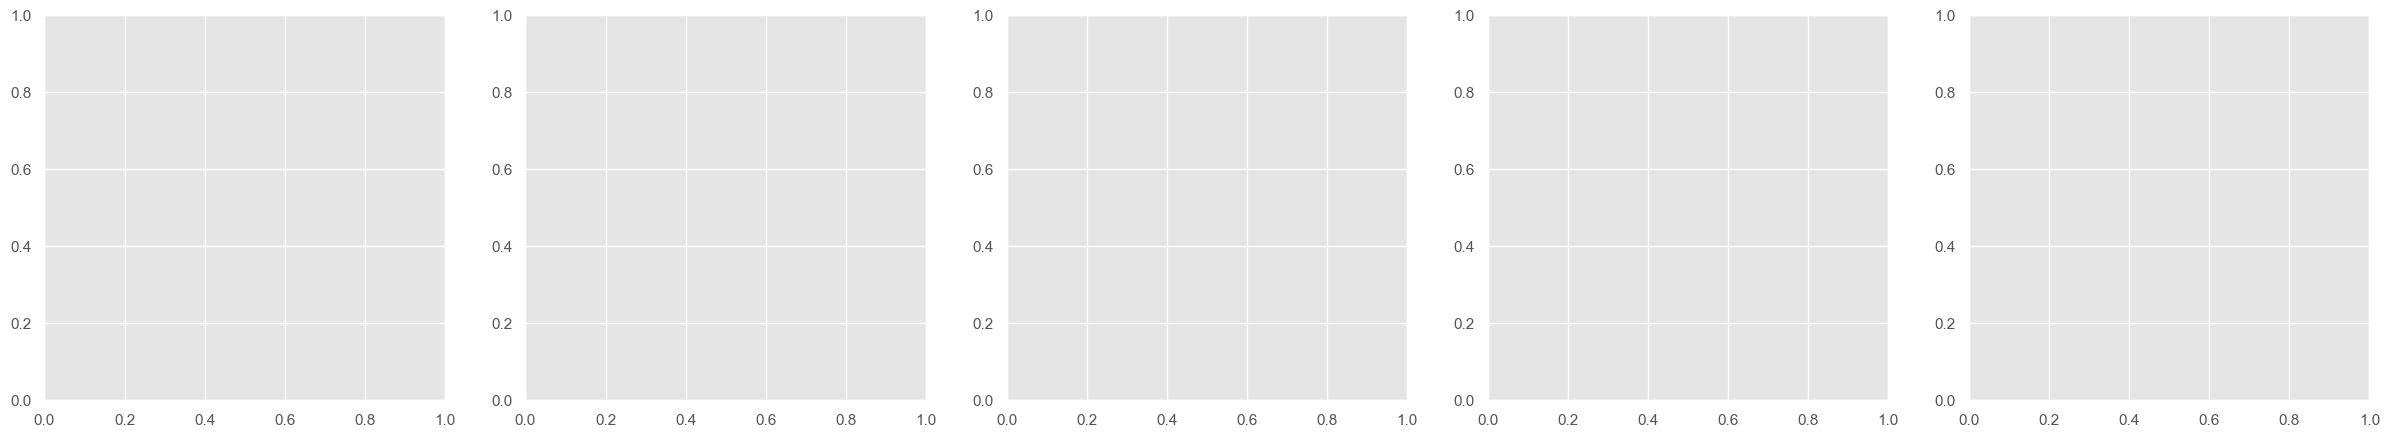

In [168]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

### Predict

The model is now ready, and it is time to test some predictions.

In order to test our assumption, we define a simple function wrapping model.predict. In particular, as we are attempting a classification between three possible labels, model.predict will return a numpy.ndarray of size three.

The softmax activation function that we used in the last layer of the model provides, indeed, the discrete probability distribution over the target classes. Therefore, we can simply take the index associated to the higher probability (np.argmax) to infer the predicted label.

In [169]:
def predict_class(texts):
  '''predict class of input text
  Args:
    - texts (list of strings)
  Output:
    - labels (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(texts)]

### Validation set evaluation

We initially split the dataset in train and test set, but we used both during the training and validation procedure.

In order to fairly estimate our performances, we evaluate the quality of the predictions on a new dataset containing observations that were not “seen” by the model during training (validation set):

In [170]:
from sklearn.metrics import classification_report

# use the validation set for making predictions
y_pred = predict_class(X_val)

# convert the predicted labels into a NumPy array
y_pred = np.array(y_pred)

# check if the true labels are in multilabel-indicator format (one-hot encoded)
if y_val.shape[1] > 1:
    # convert to multiclass format
    y_val_multiclass = np.argmax(y_val, axis=1)
else:
    y_val_multiclass = y_val    
    
# compare the predicted labels with the true labels
print(classification_report(y_val_multiclass, y_pred))

1/1 [==============================] - 6s 6s/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



---

## [Optional] Save and load the model for future use

This task is not essential to the development of a text classification model, but it is still related to the Machine Learning problem, as we might want to save the model and load it as needed for future predictions.

In [171]:
model.save("./models/text_classifier_v1")

INFO:tensorflow:Assets written to: ./models/text_classifier_v1\assets


INFO:tensorflow:Assets written to: ./models/text_classifier_v1\assets


We can now load the model as needed for future use:

In [141]:
from tensorflow import keras

# load model
new_model = keras.models.load_model("./models/text_classifier_v1")

# test predictions
[np.argmax(pred) for pred in new_model.predict(X_val)]

OSError: SavedModel file does not exist at: ./models/text_classifier_v1/assets/\{saved_model.pbtxt|saved_model.pb}

*That’s it!*